# Healthcare insurance fraud identification using PCA anomaly detection

1. [Background](#background)
1. [Setup](#setup)
1. [Data](#data)
    1. [Obtain data](#datasetfiles)
1. [Feature Engineering](#feateng)
    1. [Missing values](#missing)
    1. [Categorical features](#catfeat)
        1. [Gender](#gender)
        1. [Age Group](#age)
    1. [NLP for Textual features](#nlp)
        1. [Diagnosis Descriptions](#diagnosis)
        1. [Procedure Descriptions](#procedure)
1. [Split train & test data](#split)
    1. [Standardize](#standardize)
    1. [PCA](#pca)
1. [Calculate the Mahalanobis distance](#md)
1. [Unsupervised Anomaly Detection](#ad)
1. [Understanding Anomaly](#understandinganomaly)
1. [(Optional) Deploy PCA](#deployendpoint)

## 1. Background <a name="background"></a>
Medicare is a federal healthcare program created in 1965 with the passage of the Social Security Amendments to ensure that citizens 65 and older as well as younger persons with certain disabilities have access to quality healthcare. Medicare is administered by the Centers for Medicare and Medicaid Services (CMS). CMS manages Medicare programs by selecting official Medicare administrative contractors (MACs) to process the Medicare claims associated with various parts of Medicare. We propose a solution to apply unsupervised outlier techniques at post-payment stage to detect fraudulent patterns of received insurance claims. 

Health care insurance fraud is a pressing problem, causing substantial and increasing costs in medical insurance programs. Due to large amounts of claims submitted, review of individual claims becomes a difficult task and encourages the employment of automated pre-payment controls and better post-payment decision support tools to enable subject matter expert analysis. We will demonstrate the unsupervised anomalous outlier techniques on a minimal set of metrics made available in the CMS Medicare inpatient claims from 2008. Once more data is available as extracts from different systems  -Medicaid Information Management systems(MMIS), Medicaid Statistical Information Systems(MSIS), Medicaid Reference data such as Provider Files, Death Master Files, etc. - there is an opportunity to build a database of metrics to make the fraud detection technique more robust. The method can be used to flag claims as a targeting method for further investigation. 

## 2. Setup <a name="setup"></a>

To begin, we'll install the Python libraries we'll need for the remainder of the exercise.

In [1]:
# Upgrade numpy to latest version. Should be numpy==1.15.0 or higher to use quantile attribute
import sys
!{sys.executable} -m pip install --upgrade numpy

#If thenumpy version prints less than 1.15.0
#Go to Jupyter notebook menu on the top, click on kernal and click "Restart and Clear Output". Start from the beginning again.
import numpy as np
print(np.__version__)

    100% |████████████████████████████████| 17.3MB 2.6MB/s eta 0:00:01
mxnet-mkl 1.4.0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.16.4 which is incompatible.
mxnet-cu90mkl 1.4.0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.16.4 which is incompatible.
  Found existing installation: numpy 1.14.5
    Uninstalling numpy-1.14.5:
      Successfully uninstalled numpy-1.14.5
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
1.16.4


In [2]:
# Install a pip columnize package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install columnize gensim

    100% |████████████████████████████████| 24.2MB 1.6MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 25.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/b8/cb/43/c0ba52baf2b0e371ec1d5b2d4685d6d24617b1391f3eeacda5
Successfully built smart-open
mxnet-mkl 1.4.0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.16.4 which is incompatible.
mxnet-cu90mkl 1.4.0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.16.4 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# unInstall seaborn==0.8 in the Jupyter kernel. seaborn==0.9 or higher is required for seaborn pair plot that we plan to use for visulization in this notebook.
import sys
!{sys.executable} -m pip uninstall seaborn -y

Uninstalling seaborn-0.8.1:
  Successfully uninstalled seaborn-0.8.1
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
# Install seaborn==0.9 in the Jupyter kernel
import sys
!{sys.executable} -m pip install seaborn

    100% |████████████████████████████████| 215kB 32.8MB/s ta 0:00:01
mxnet-mkl 1.4.0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.16.4 which is incompatible.
mxnet-cu90mkl 1.4.0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.16.4 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
# check if sns resolves to 0.9.0. If it still shows version 0.8.0, 
#go to Jupyter notebook menu on the top, click on kernal and click "Restart and Clear Output" 
import seaborn as sns
print(sns.__version__)

0.9.0


Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [6]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import boto3                                      #enables Python developers to create, configure, and manage AWS services
from IPython.display import display               # For displaying outputs in the notebook
import matplotlib.pyplot as plt                   #for interactive plots and simple cases of programmatic plot generation
%matplotlib inline                                
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        #provides access to some variables used or maintained by the interpreter
import os                                         # For manipulating filepath names
import sagemaker                                  #open source library for training and deploying machine-learned models on Amazon SageMaker
import time                                       #provides various time-related functions
import warnings                                   #allows you to handle all warnings with the standard logging
import io                                         #interface to access files and streams
import sagemaker.amazon.common as smac            #provides common function used for training and deploying machine-learned models on Amazon SageMaker
warnings.filterwarnings(action = 'ignore')        #warnings filter controls whether warnings are ignored, displayed
from sklearn.model_selection import train_test_split #Quick utility to split data into train and test set
import gensim                                     #topic modelling library for Python that provides access to Word2Vec
import columnize                                  #format a simple (i.e. not nested) list into aligned columns.
from gensim.models import Word2Vec                #topic modelling library for Python that provides access to Word2Vec
from sklearn.manifold import TSNE                 #containing T-SNE algorithms used to project high dimensional space into lower dimesional space
from numpy.linalg import inv                      #Compute the dot product of two or more arrays in a single function call
import scipy.stats                                #contains a large number of probability distributions for statistical analysis
import scipy as sp                                #collection of mathematical algorithms
import seaborn as sns                             #data visualization library based on matplotlib
import mxnet as mx                                #open-source deep learning software framework, used to train, and deploy deep neural networks.

This notebook was created and tested on an ml.m4.xlarge and ml.t3.xlarge notebook instance.

We first need to specify some AWS credentials; specifically data locations and access roles. This is the only cell of this notebook that you will need to edit. In particular, we need the following data:

* `bucket` - An S3 bucket accessible by this account.
  * Used to store input training data and model data output.
  * Should be withing the same region as this notebook instance, training, and hosting.
* `prefix` - The location in the bucket where this notebook's input and and output data will be stored. (The default value is sufficient.)
* `role` - The IAM Role ARN used to give training and hosting access to your data.
  * See documentation on how to create these.
  * The script below will try to determine an appropriate Role ARN.
  
#### Note: Pick a unique s3 bucket name before you execute the cell below, update 'bucket' variable with new name.

In [8]:
from sagemaker import get_execution_role
import boto3, os
s3 = boto3.resource('s3')

role = get_execution_role()
# Assign a unique name to the bucket. S3 buckets should have unique global name.
bucket = '<unique-alias>-aim302-30-may-2019'
prefix = 'sagemaker/healthcare-fraud-detection'
s3.create_bucket(Bucket=bucket)

print('Training input/output will be stored in {}/{}'.format(bucket, prefix))
print('\nIAM Role: {}'.format(role))

Training input/output will be stored in awsvik-aim302-30-may-2019/sagemaker/healthcare-fraud-detection

IAM Role: arn:aws:iam::386258261521:role/service-role/AmazonSageMaker-ExecutionRole-20180430T144086


## 3. Data<a name="data"></a>

The dataset we'll be using in this example was downloaded from following link.
https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Inpatient_Claims.html

The data set is the public available Basic Stand Alone (BSA) Inpatient Public Use Files (PUF) named “CMS 2008 BSA Inpatient Claims PUF”. The file contains Medicare inpatient claims from 2008. Each record is an inpatient claim incurred by a 5% sample of Medicare beneficiaries. The file contains seven (7) variables: A primary claim key indexing the records and six (6) analytic variables. One of the analytic variables, claim cost, is provided in two forms, (a) as an integer category and (b) as a dollar average. There are some demographic and claim-related variables provided in this PUF. 

However, as beneficiary identities are not provided, it is not possible to link claims that belong to the same beneficiary in the CMS 2008 BSA Inpatient Claims PUF. Without linking beneficiary Id to the claims, it is not possible to create features such as 'amount reimbursed over time', 'average reimbursement per visit' etc.

### 3A. Obtain data<a name="datasetfiles"></a>

We will use the following link to download claims dataset.

https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF.zip

The data dictionary required to interpret codes in dataset have been constructed from following pdf document.

https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF_DataDic_CB.pdf

Following dictionary files are already avaliable in data folder in the notebook.
- `ColumnNames.csv` - column description
- `DiagnosisRelatedGroupNames.csv` - dictionary for procedure codes
- `InternationalClassificationOfDiseasesNames.csv` - dictionary of diagnosis codes
- `LengthOfStayDays.csv` - dictionary of length of stay
- `AgeGroup.csv` - dictionary of age group
- `Gender.csv` - dictionary of gender

#### Download claims data file from CMS site.

In [9]:
!wget https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF.zip
!unzip -o ./2008_BSA_Inpatient_Claims_PUF.zip -d data

--2019-05-29 15:43:08--  https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF.zip
Resolving www.cms.gov (www.cms.gov)... 23.218.130.67, 2600:1408:3000:281::28a, 2600:1408:3000:2a3::28a
Connecting to www.cms.gov (www.cms.gov)|23.218.130.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8848030 (8.4M) [application/zip]
Saving to: ‘2008_BSA_Inpatient_Claims_PUF.zip’

2008_BSA_Inpatient_ 100%[===================>]   8.44M  14.6MB/s    in 0.6s    

2019-05-29 15:43:09 (14.6 MB/s) - ‘2008_BSA_Inpatient_Claims_PUF.zip’ saved [8848030/8848030]

Archive:  ./2008_BSA_Inpatient_Claims_PUF.zip
  inflating: data/2008_BSA_Inpatient_Claims_PUF.csv  


#### The data file have been extrcated under data folder locally on Sagemaker notebook volume in the data folder.

- `2008_BSA_Inpatient_Claims_PUF.csv` - claims data

#### Let's begin exploring data:

## 4. Feature Engineering <a name="feateng"></a>

In [10]:
# read the ColumnNames csv file to identify meaningful names for column labels in the claim data
colnames = pd.read_csv("./data/ColumnNames.csv")
colnames[colnames.columns[-1]] = colnames[colnames.columns[-1]].map(lambda x: x.replace('"','').strip())
display(colnames)

,Column Label,"""Column Name"""
0,IP_CLM_ID,Encrypted PUF ID
1,BENE_SEX_IDENT_CD,Beneficiary gender code
2,BENE_AGE_CAT_CD,Beneficiary Age category code
3,IP_CLM_BASE_DRG_CD,Base DRG code
4,IP_CLM_ICD9_PRCDR_CD,ICD9 primary procedure code
5,IP_CLM_DAYS_CD,Inpatient days code
6,IP_DRG_QUINT_PMT_AVG,DRG quintile average payment amount
7,IP_DRG_QUINT_PMT_CD,DRG quintile payment amount code


In [11]:
# read claims data file
df_cms_claims_data = pd.read_csv('./data/2008_BSA_Inpatient_Claims_PUF.csv')
df_cms_claims_data.columns = colnames[colnames.columns[-1]].ravel()
pd.set_option('display.max_columns', 500)

# print the shape of the data file
print('Shape:', df_cms_claims_data.shape)

# show the top few rows
display(df_cms_claims_data.head())

# describe the data object
display(df_cms_claims_data.describe())

# check the datatype for each column
display(df_cms_claims_data.dtypes)

# check null value for each column
display(df_cms_claims_data.isnull().mean())

Shape: (588415, 8)


,Encrypted PUF ID,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code
0,IP-000022CE4125DBE7,2,4,3,31.0,4,86240,4
1,IP-0000417F50942D90,2,5,199,NaN,2,3447,2
2,IP-0000865F5457AC0E,1,1,119,54.0,4,34878,5
3,IP-00009789630AF474,2,2,128,NaN,2,3007,2
4,IP-0000C9D229B79D36,2,2,236,70.0,1,3352,2


,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code
count,588415.000000,588415.000000,588415.000000,311869.000000,588415.000000,588415.000000,588415.000000
mean,1.561165,3.574610,140.202393,59.683832,2.516377,9312.621422,2.999444
std,0.496245,1.805788,79.686699,29.207527,0.972758,10482.707298,1.414880
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,1.000000,2.000000,82.000000,38.000000,2.000000,4008.000000,2.000000
50%,2.000000,4.000000,123.000000,54.000000,2.000000,6352.000000,3.000000
75%,2.000000,5.000000,200.000000,86.000000,3.000000,10760.000000,4.000000
max,2.000000,6.000000,311.000000,99.000000,4.000000,329467.000000,5.000000


Encrypted PUF ID                        object
Beneficiary gender code                  int64
Beneficiary Age category code            int64
Base DRG code                            int64
ICD9 primary procedure code            float64
Inpatient days code                      int64
DRG quintile average payment amount      int64
DRG quintile payment amount code         int64
dtype: object

Encrypted PUF ID                       0.000000
Beneficiary gender code                0.000000
Beneficiary Age category code          0.000000
Base DRG code                          0.000000
ICD9 primary procedure code            0.469985
Inpatient days code                    0.000000
DRG quintile average payment amount    0.000000
DRG quintile payment amount code       0.000000
dtype: float64

#### You might have observed some 'NaN' and mean value(0.469985) for ICD9 primary procedure code in print results above.
We need fix to 'NaN' in ICD9 primary procedure code.

### 4A. Missing values<a name="missing"></a>
Do I have missing values? How are they expressed in the data? Should I withhold samples with missing values? Or should I replace them? If so, which values should they be replaced with?

Based on results of isnull.mean(), it is clear that 'ICD9 primary procedure code' has a non zero mean and it is so because it has NaN values. The NaN values corresponds to "No Procedure Performed" in the  in the 'ICD9 primary procedure code' dictionary. Let's replace NaN values with a numeric code for "No Procedure Performed".

In [12]:
#Fill NaN with -1 for "No Procedure Performed"
procedue_na = -1
df_cms_claims_data['ICD9 primary procedure code'].fillna(procedue_na, inplace = True)

#convert procedure code from float to int64
df_cms_claims_data['ICD9 primary procedure code'] = df_cms_claims_data['ICD9 primary procedure code'].astype(np.int64)


#check count of null values to ensure dataframe is updated
display(df_cms_claims_data.isnull().mean())

Encrypted PUF ID                       0.0
Beneficiary gender code                0.0
Beneficiary Age category code          0.0
Base DRG code                          0.0
ICD9 primary procedure code            0.0
Inpatient days code                    0.0
DRG quintile average payment amount    0.0
DRG quintile payment amount code       0.0
dtype: float64

### 4B. Categorical features <a name="catfeat"></a>

Munging categorical data is another essential process during data preprocessing. It is necessary to convert categorical features to a numerical representation.

#### a. Gender <a name="gender"></a>

Since gender is already binary and coded as 1 for Male and 2 for Female, no pre-processing is required.

,bene_sex_ident_cd,Beneficiary gender
0,1,Male
1,2,Female


Text(0,0.5,'Percentage claims')

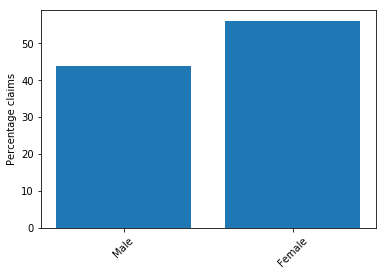

In [13]:
# read gender dictionary csv file
dict_gender = pd.read_csv("./data/Gender.csv")
dict_gender.columns = dict_gender.columns.to_series().apply(lambda x: x.strip())
display(dict_gender)

# join the beneficiary category code with age group definition and describe the distribution amongst different age group in claims dataset
tmp_gender_counts = dict_gender.set_index('bene_sex_ident_cd').join( df_cms_claims_data['Beneficiary gender code'].value_counts() )
tmp_gender_counts['percentage'] = tmp_gender_counts['Beneficiary gender code']/tmp_gender_counts['Beneficiary gender code'].sum()*100

# project gender distribution in the dataset on the bar graph
plt.bar(tmp_gender_counts.index, tmp_gender_counts['percentage'].tolist());
plt.xticks(tmp_gender_counts.index, tmp_gender_counts['Beneficiary gender'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

#### You may have observed a slight imbalance in claims distribution for male and female records in above bar graph.
Nothing concerning hear. But, we may use this information later in result analysis to justify our anomaly hypothesis.

#### b. Age Group <a name="age"></a>

,BENE_AGE_CAT_CD,Age Group
0,1,Under_65
1,2,65_to_69
2,3,70_to_74
3,4,75_to_79
4,5,80_to_84
5,6,85_and_Older


Text(0,0.5,'Percentage claims')

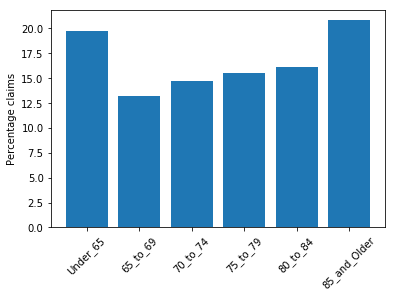

In [14]:
#read AgeGroup csv file into a pandas dataframe
dict_age_group = pd.read_csv("./data/AgeGroup.csv", sep=',')
dict_age_group.columns = dict_age_group.columns.to_series().apply(lambda x: x.strip())
display(dict_age_group)

# join the beneficiary category code with age group definition and describe the distribution amongst different age group in claims dataset
tmp_age_sorted_counts = dict_age_group.set_index('BENE_AGE_CAT_CD').join( df_cms_claims_data['Beneficiary Age category code'].value_counts() )
tmp_age_sorted_counts['percentage'] = tmp_age_sorted_counts['Beneficiary Age category code']/tmp_age_sorted_counts['Beneficiary Age category code'].sum()*100

# project age group distribution in the dataset on the bar graph
plt.bar(tmp_age_sorted_counts.index, tmp_age_sorted_counts['percentage'].tolist());
plt.xticks(tmp_age_sorted_counts.index, tmp_age_sorted_counts['Age Group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

#### You might have observed a slight imbalance in age group group distribution. 
Nothing concerning in above distribution. Small imbalance is OK.

### 4B. NLP for Textual features <a name="nlp"></a>

All physician and hospital claims include one or more diagnosis codes. The ICD-9-CM diagnosis coding system is used since October, 2012.

Hospital inpatient claims also include one or more procedure codes that represent the services performed. The ICD-9-CM diagnosis coding system is used since October, 2012.

The codes are numeric number representing the phrases describing the diagnosis and the procedures itself. The code iteself is numberic but doesn't capture context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

For diagnosis and procedure codes there is a option to consider it as categorical code and apply one hot encoding to it. That categorical data is defined as variables with a finite set of label values. We apply a technique called one hot encoding to do binarization of such values. In one hot encode we create one column for each label value and mark it as 0 or 1 as applicable to sample record. In case of dignosis code and procedure code it will give us a sparse matrix. Again, the code iteself will be numberic but doesn't capture context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Inorder to capture, capture context of a word in a document, semantic and syntactic similarity, relation with other words, etc. we use a technique called word embedding to convert every word in a phrase into a vector of floating point numbers. We then average the vector for each word in a phrase to derive vector for a phrase. We will use this approach for both diagnosis and procedure descriptions to extract features.

Word2Vec is a specific method to derieve word embeddings. It can be done using two methods (both involving Neural Networks): Skip Gram and Common Bag Of Words (CBOW)

CBOW Model: This method takes the context of each word as the input and tries to predict the word corresponding to the context.

Skip-Gram model: This method uses the target word (whose representation we want to generate) to predict the context and in the process, we produce the representations.

Both model have their own advantages and disadvantages. Skip Gram works well with small amount of data and is found to represent rare words well.

On the other hand, CBOW is faster and has better representations for more frequent words.

In our use case, we will use CBOW model to derieve wordtovec for pharases used to describe procedure and diagnosis code description.

#### a. Diagnosis Descriptions <a name="diagnosis"></a>

,Base DRG code,Diagnosis related group
0,1,Heart transplant or implant of heart assist sy...
1,2,"ECMO or trach w MV 96+ hrs or PDX exc face, mo..."
2,3,"Trach w MV 96+ hrs or PDX exc face, mouth & ne..."
3,4,Liver transplant
4,5,Lung transplant


Base DRG code               int64
Diagnosis related group    object
dtype: object

Text(0,0.5,'Percentage claims')

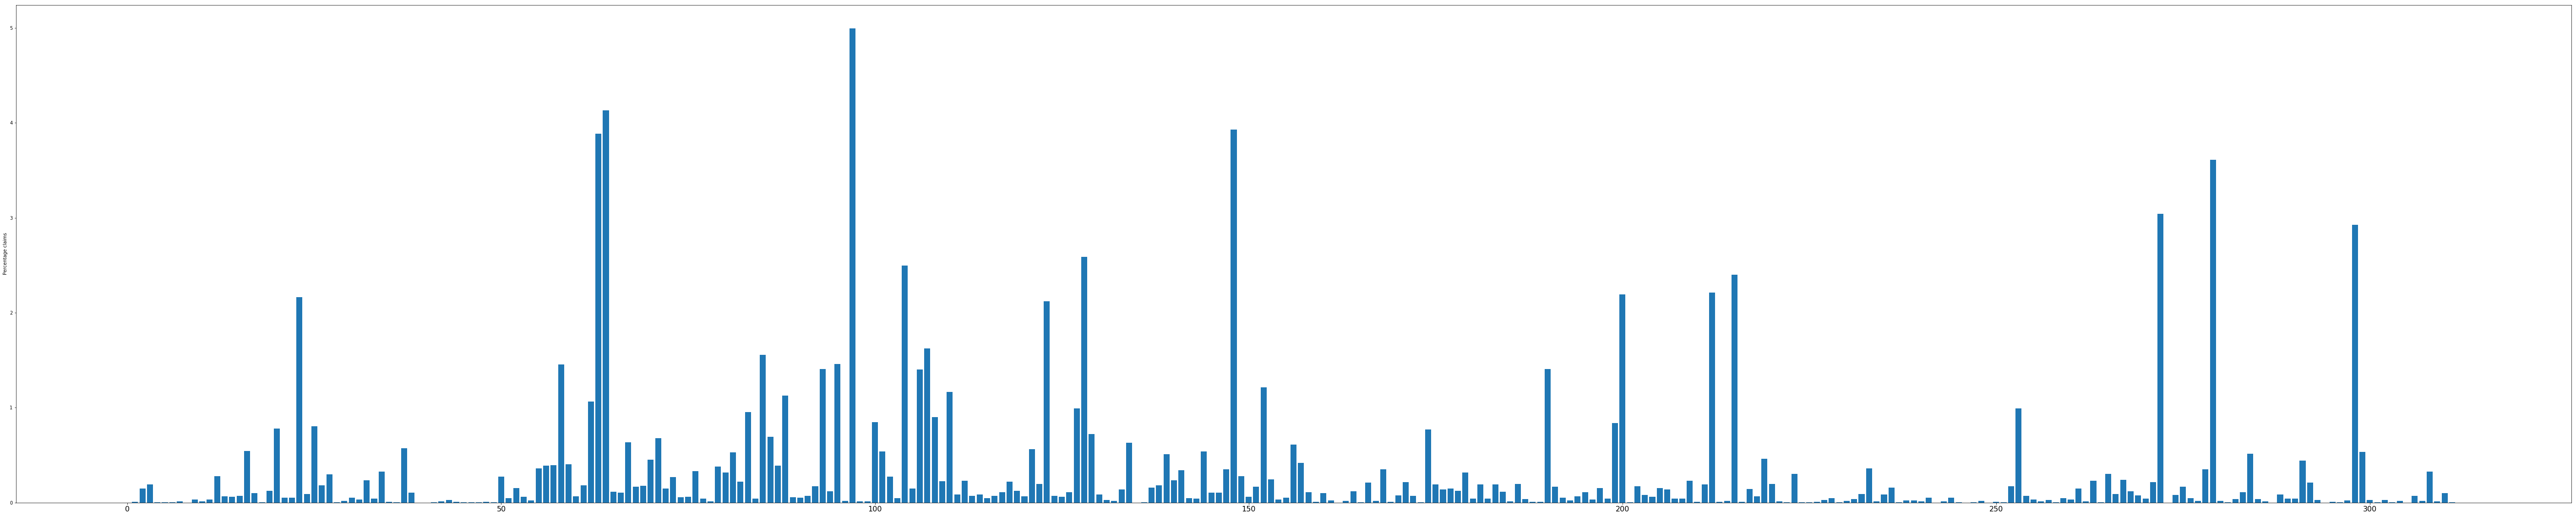

In [15]:
# read the diagnosis names into dataframe, clean up values and display records
dict_diagnosis_names = pd.read_csv('./data/DiagnosisRelatedGroupNames.csv', sep=', "', skiprows=1, names=['Base DRG code','Diagnosis related group']);
dict_diagnosis_names['Diagnosis related group'] = dict_diagnosis_names['Diagnosis related group'].map(lambda x: x.replace('"',''));
display(dict_diagnosis_names.head())
display(dict_diagnosis_names.dtypes)


# join the Base DRG code in dictionay with Base DRG code in claims dataframe and describe the distribution amongst different age group in claims dataset
tmp_diagnosis_counts = dict_diagnosis_names.set_index('Base DRG code').join( df_cms_claims_data['Base DRG code'].value_counts() )
tmp_diagnosis_counts['percentage'] = tmp_diagnosis_counts['Base DRG code']/tmp_diagnosis_counts['Base DRG code'].sum()*100

# project age group distribution in the dataset on the bar graph
plt.figure(figsize=(100,20))
plt.rc('xtick', labelsize=16)
plt.bar(tmp_diagnosis_counts.index, tmp_diagnosis_counts['percentage'].tolist());
#plt.xticks(tmp_diagnosis_counts.index, tmp_diagnosis_counts['Diagnosis related group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

#### Observe the distribution of different diagnosis code in above bar graph printed from claims dataset.
Next, let's do text processing on diagnosis descriptions to make some of the acronyms more meaningful for word embeddings

In [ ]:
# function to run pre processing on diagnosis descriptions
from nltk.tokenize import sent_tokenize, word_tokenize 

def text_preprocessing(phrase):
    phrase = phrase.lower()
    phrase = phrase.replace('&', 'and')
    #phrase = phrase.replace('non-', 'non') #This is to ensure non-critical, doesn't get handled as {'non', 'critical'}
    phrase = phrase.replace(',','')
    phrase = phrase.replace('w/o','without').replace(' w ',' with ').replace('/',' ')
    phrase = phrase.replace(' maj ',' major ')
    phrase = phrase.replace(' proc ', ' procedure ')
    phrase = phrase.replace('o.r.', 'operating room')
    sentence = phrase.split(' ')
    return sentence

In [ ]:
# run pre processing on diagnosis related group
tmp_diagnosis_tokenized = dict_diagnosis_names['Diagnosis related group'].map(lambda x: text_preprocessing(x))
display(tmp_diagnosis_tokenized.head())

In [ ]:
# build a map of number of tokens in a phrase to number of phrases with speific number of phrases
diagnosis_phrase_lengths = tmp_diagnosis_tokenized.map(lambda x: len(x)).value_counts().sort_index()

# plot count of tokens in phrase on x-axis and number of phrases with a specific count of tokens in y-axis
plt.bar(np.arange(1,1+len(diagnosis_phrase_lengths)), diagnosis_phrase_lengths)
plt.xlabel('Number of Tokens');
plt.ylabel('Phrases');

#### Word to vec hyperparameters explained

**size:** The size of the dense vector that is to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. A value of 100–150 has worked well for me for similarity lookups.

**window:** The maximum distance between the target word and its neighboring word. If your neighbor’s position is greater than the maximum window width to the left or the right, then some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its not overly narrow or overly broad. If you are not too sure about this, just use the default value.

**min_count:** Minimium frequency count of words. The model would ignore words that do not satisfy the min_count.Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

**workers:** How many threads to use behind the scenes?

**iter:** How many epochs to train for? I typically use 10 or more for a small to medium dataset.

In [ ]:
# traing wordtovec model on diagnosis description tokens
model_drg = Word2Vec(tmp_diagnosis_tokenized, min_count = 1, size = 72, window = 5, iter = 30)
print(model_drg)
diagnosis_words = list(model_drg.wv.vocab)
print(columnize.columnize(diagnosis_words, displaywidth=80, ljust=False))

#### t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

In [ ]:
# plot TSNE visualization
from sklearn.manifold import TSNE
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=10)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
# plot t_SNE chart for diagnosis word to vector. 
#2D visual plot of word embeddings derieved from diagnosis description.
tsne_plot(model_drg)

In [ ]:
# test most similiar for some word from model_drg.wv.keywords
model_drg.most_similar('diagnosis')

In [ ]:
# extract diagnosis words that starts with non
#display(tmp_diagnosis_tokenized.head())
series_diagnosis = pd.Series(diagnosis_words)
diagnosis_words_with_non = series_diagnosis[series_diagnosis.map(lambda x: 'non' in x)]
display(diagnosis_words_with_non)

In [ ]:
# Check similarity between diagnosis words with opposite severity
for i in diagnosis_words_with_non:
    a, not_a = i.replace('non-','').replace('non',''), i
    if a in diagnosis_words:
        print('Cosine similarity between', a, not_a, ':', model_drg.wv.similarity(a, not_a))
        print('')

In [ ]:
# calculate mean of word vector in a phrase to derieve phrase vector for diagnosis description
# we plan to use mean of word vectors to derive word embeddings for a phrase
values = []
index =[]
#iterate through list of strings in each diagnosis phrase
for i, v in pd.Series(tmp_diagnosis_tokenized).items():
    #calculate mean of all word embeddings in each diagnosis phrase
    values.append(model_drg[v].mean(axis =0))
    index.append(i)
tmp_diagnosis_phrase_vector = pd.DataFrame({'Base DRG code':index, 'DRG_VECTOR':values})
display(tmp_diagnosis_phrase_vector.head())

In [ ]:
# expand tmp_diagnosis_phrase_vector into dataframe
# every scalar value in phrase vector will be considered a feature
diagnosis_features = tmp_diagnosis_phrase_vector['DRG_VECTOR'].apply(pd.Series)

# rename each variable in diagnosis_features use DRG_F as prefix
diagnosis_features = diagnosis_features.rename(columns = lambda x : 'DRG_F' + str(x + 1))

# view the diagnosis_features dataframe
display(diagnosis_features.head())

#### b. Procedure Descriptions <a name="procedure"></a>

Apply the same process that we used for diagnosis description to procedure description to build a feature vector for procedure

In [ ]:
#read procedure code and procedure description mappings
dict_procedure_names = pd.read_csv('./data/InternationalClassificationOfDiseasesNames.csv', 
                              sep=', "', 
                              skiprows=1, 
                              names=['ICD9 primary procedure code','International Classification of Diseases'])

#replace double quotes with blank
dict_procedure_names = dict_procedure_names.applymap(lambda x: x.replace('"',''))

# replace -1 as code for 'No procedure performed'. In the dictionary the code is set as blank.
dict_procedure_names.iloc[0]['ICD9 primary procedure code'] = procedue_na

# convert procedure code from float to int64
dict_procedure_names['ICD9 primary procedure code'] = dict_procedure_names['ICD9 primary procedure code'].astype(np.int64)


# check the datatype for each column
display(dict_procedure_names.dtypes)

# display first five records in dictionary
display(dict_procedure_names.head())


In [ ]:
display(dict_procedure_names.count())

In [ ]:
# join the ICD9 primary procedure code in dictionay with ICD9 primary procedure code in claims dataframe and plot the distribution of procedures in the claims dataset
tmp_procedure_counts = dict_procedure_names.set_index('ICD9 primary procedure code').join(df_cms_claims_data['ICD9 primary procedure code'].value_counts() )
tmp_procedure_counts['percentage'] = tmp_procedure_counts['ICD9 primary procedure code']/tmp_procedure_counts['ICD9 primary procedure code'].sum()*100

# project procedure distribution in the claims dataset on the bar graph
plt.figure(figsize=(100,25))
plt.rc('xtick', labelsize=16)
plt.bar(tmp_procedure_counts.index, tmp_procedure_counts['percentage'].tolist());
#plt.xticks(tmp_diagnosis_counts.index, tmp_diagnosis_counts['Diagnosis related group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

In [ ]:
# run pre processing on procedure descriptions
tmp_procedure_tokenized = dict_procedure_names['International Classification of Diseases'].map(lambda x: text_preprocessing(x))
display(tmp_procedure_tokenized.head())

In [ ]:
# build a map of number of tokens in a phrase to number of phrases with speific number of phrases
procedure_phrase_lengths = tmp_procedure_tokenized.map(lambda x: len(x)).value_counts().sort_index()

# plot count of tokens in phrase on x-axis and number of phrases with a specific count of tokens in y-axis
plt.bar(np.arange(1,1+len(procedure_phrase_lengths)), procedure_phrase_lengths)
plt.xlabel('Number of Tokens');
plt.ylabel('Phrases');

In [ ]:
# traing wordtovec model on procedure description tokens
model_prc = Word2Vec(tmp_procedure_tokenized, min_count = 1, size = 72, window = 5, iter = 100)
print(model_prc)
procedure_words = list(model_prc.wv.vocab)
print(columnize.columnize(procedure_words, displaywidth=80, ljust=False))

In [ ]:
# plot t_SNE chart for procedure word to vector
# #2D visual plot of word embeddings derieved from procedure description.
tsne_plot(model_prc)

In [ ]:
# test most similiar for some word from model_prc.wv.keywords
model_prc.most_similar('nonoperative')

In [ ]:
# extract procedure words that starts with non
#display(tmp_procedure_tokenized.head())
series_procedure = pd.Series(procedure_words)
procedure_words_with_non = series_procedure[series_procedure.map(lambda x: 'non' in x)]
display(procedure_words_with_non)

In [ ]:
# Check similarity between procedure words with opposite severity
for i in procedure_words_with_non:
    a, not_a = i.replace('non-','').replace('non',''), i
    if a in procedure_words:
        print('Cosine similarity between', a, not_a, ':', model_prc.wv.similarity(a, not_a))
        print('')

In [ ]:
# calculate mean of word vector in a phrase to derieve phrase vector for procedure description 
values = []
index =[]
#iterate through list of strings in each procedure phrase
for i, v in pd.Series(tmp_procedure_tokenized).items():
    #calculate mean of all word embeddings in each procedure phrase
    values.append(model_prc[v].mean(axis =0))
    index.append(i)
tmp_procedure_phrase_vector = pd.DataFrame({'ICD9 primary procedure code':index, 'PRC_VECTOR':values})
display(tmp_procedure_phrase_vector.head())

In [ ]:
# expand tmp_procedure_phrase_vector into dataframe
# every scalar value in phrase vector will be considered a feature
procedure_features = tmp_procedure_phrase_vector['PRC_VECTOR'].apply(pd.Series)

# rename each variable in procedure_features use PRC_F as prefix
procedure_features = procedure_features.rename(columns = lambda x : 'PRC_F' + str(x + 1))

# view the procedure_features dataframe
display(procedure_features.head())

In [ ]:
#merge diagnosis word embeddings derived using word2vec in the base claims data as new features.
tmp_join_claim_diagnosis = pd.merge(df_cms_claims_data, diagnosis_features, how='inner', left_on = 'Base DRG code', right_index = True)
display(tmp_join_claim_diagnosis.head())

#merge procedure word embeddings derived using word2vec in the base claims data as new features.
tmp_join_claim_procedure = pd.merge(tmp_join_claim_diagnosis, procedure_features, how='inner', left_on = 'ICD9 primary procedure code', right_index = True)
display(tmp_join_claim_procedure.head())

#assign new feature set with procedure and diagnosis work embeddings to a new claims feature dataframe
#aggregate all the features extrcated so far to build a final claims feature set for training
claims_features = tmp_join_claim_procedure


## 5. Split train and test: train only on normal data <a name="split"></a>

We want to split our data into training and test sets. We want to ensure that in this random split we have samples that cover the distribution of payments. We perform a stratified shuffle split on the DRG quintile payment amount code, taking 30% of the data for testing and 70% for training.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

X = claims_features.drop(['Encrypted PUF ID','ICD9 primary procedure code','Base DRG code'], axis=1)
strata = claims_features['DRG quintile payment amount code']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
splits = sss.split(X, strata)
for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

In [ ]:
display(X.head())
X.shape

## 5A. Standardize data based on training sample <a name="standardize"></a>

Because the PCA algorithm that we will use later for training maximizes the orthogonal variances of one's data, it is important to standardize the training data to have zero-mean and unit-variance prior to performing PCA. This way your PCA algorithm is idempotent to such rescalings, and prevent variables of large scale from dominating the PCA projection.

$$ \tilde{X} = \frac{X-\mu_x}{\sigma_z} $$

In [ ]:
n_obs, n_features = X_train.shape

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_stndrd_train = scaler.transform(X_train)
X_stndrd_train = pd.DataFrame(X_stndrd_train, index=X_train.index, columns=X_train.columns)

### 5B. PCA <a name="pca"></a>

Principal Component Analysis (PCA) is an unsupervised method for taking a data set where features have multi-collinearity and creating a decorrelated data set, by finding the linear combination of vectors which maximize the data's variances in orthogonal dimensions. 

#### PCA  on Amazon SageMaker 

The built-in PCA algorithm of SageMaker solves for the singular values, $s$, and for the Principal Components, $V$, of our data set. Here we'll perform SageMaker PCA on our standardized training dataset $\tilde{X}$, and then we'll use its outputs to project our correlated dataset into a decorrelated one.

$$ s, V = \rm{PCA}(\tilde{X})$$

In [ ]:
# Convert data to binary stream.
matrx_train = X_stndrd_train.as_matrix().astype('float32')
import io
import sagemaker.amazon.common as smac
buf_train = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf_train, matrx_train)
buf_train.seek(0)

Now we are ready to upload the file object to our Amazon S3 bucket. We specify two paths: one to where our uploaded matrix will reside, and one to where Amazon SageMaker will write the output. Amazon SageMaker will create folders within the paths that do not already exist.

In [ ]:
%%time

key = 'healthcare_fraud_identification_feature_store'
prefix = 'sagemaker/pca-anol'

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf_train)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output/model'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri
# select the algorithm container based on this notebook's current location

region_name = boto3.Session().region_name
container = get_image_uri(region_name, 'pca')

print('Using SageMaker PCA container: {} ({})'.format(container, region_name))

#### Start the Amazon Sagemaker Session and set training parameters for Estimator API

Instance type should be one of the following and number of instances can be greater than 1. Option to train on P instance type family to use GPUs for training

#### [ml.p2.xlarge, ml.m5.4xlarge, ml.m4.16xlarge, ml.p3.16xlarge, ml.m5.large, ml.p2.16xlarge, ml.c4.2xlarge, ml.c5.2xlarge, ml.c4.4xlarge, ml.c5.4xlarge, ml.c4.8xlarge, ml.c5.9xlarge, ml.c5.xlarge, ml.c4.xlarge, ml.c5.18xlarge, ml.p3.2xlarge, ml.m5.xlarge, ml.m4.10xlarge, ml.m5.12xlarge, ml.m4.xlarge, ml.m5.24xlarge, ml.m4.2xlarge, ml.p2.8xlarge, ml.m5.2xlarge, ml.p3.8xlarge, ml.m4.4xlarge]

In [ ]:
num_obs, feature_dim = np.shape(matrx_train)
num_components = feature_dim-1
num_instances=2
instance_type = 'ml.c5.2xlarge'
algorithm_mode='regular'
platform='sagemaker'


start = time.time()

sess = sagemaker.Session()

pca = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=num_instances, 
                                    train_instance_type=instance_type,
                                    output_path=output_location,
                                    sagemaker_session=sess)

#### Specify the hyperparameters for your training job and start the training using Amazon SageMaker fit API call

Training will take approximately 4-5 minutes to complete.

In [ ]:
pca.set_hyperparameters(feature_dim=feature_dim,
                        num_components=num_components,
                        subtract_mean=False,
                        algorithm_mode='regular',
                        mini_batch_size=200)

print('Start timestamp of launch: '+ str(start))
pca.fit({'train': s3_train_data})

stop = time.time()
total_time = stop-start
print('%2.2f minutes' %(total_time/60))

When the training job is complete, SageMaker writes the model artifact to the specified S3 output location. Let's download and unpack returned PCA model artifact. 

In [ ]:
job_name = pca.latest_training_job.name
os.system('aws s3 cp {}/{}/output/model.tar.gz ./'.format(output_location, job_name))
!tar xvzf model.tar.gz

pca_model = mx.ndarray.load('model_algo-1')
print('PCA model artifact:', pca_model.keys())

SageMaker PCA artifact contains $V$, the eigenvector principal components in *increasing* order of $s$, their singular values. A component's singular value is equal to the standard deviation that the component explains, i.e., the squared value of a singular component is equal to the variance that component explains. Therefore to calculate the proportion of variance of the data that each component explains, take the square of the singular value and divide it by the sum of all the singular values squared:
$$ \rm{component \,}i \% \rm{\,variance\,  explained} =  100\cdot\frac{s_i^s}{\sum_{p=1}^P s_p^2} $$


First, we'll reverse this returned ordering, so that instead we have the components which explain the most variance come first, i.e., reorder the components in decreasing order of their singular values.


PCA can be further used to reduce the dimensionality of the problem. We have $P$ features and $P-1$ components, but we'll see in the plot below that many of the components don't contribute much to the explained variance of the data. We will keep only the $K$ leading components of $V$ which  explain 95% of the variance in our data. 

We will denote this reduced matrix as $V_K$.

In [ ]:
singular_values = pca_model['s'].asnumpy()[::-1]
pc_reversedorder = pd.DataFrame(pca_model['v'].asnumpy())
pc = pc_reversedorder[list(pc_reversedorder.columns[::-1])]

eigenvalues = np.power(singular_values,2)
explained_var_pct = eigenvalues/np.sum(eigenvalues) *100
explained_var_cum = np.cumsum(explained_var_pct)

var_threshold = 95
n_components = np.min([np.where(explained_var_cum>=var_threshold)[0][0], n_features-1])
print('%i components explain %2.2f%% of the data\'s variance.' %(n_components+1, explained_var_cum[n_components]))

fig= plt.figure(figsize=[14,8])
width = 0.5
ax1 = fig.add_subplot(111)
ax1.bar(np.arange(0,len(singular_values)), singular_values, align='edge',  color='darkgreen', label='Singular Values', alpha=0.5, width=width);
ax1.set_ylabel('Singular Values', fontsize=17);
ax1.set_xlabel('Principal Component', fontsize=17);
ax1.legend(loc='upper right', fontsize=14)
ax2 = ax1.twinx()
ax2.plot(np.arange(0,len(explained_var_cum)), explained_var_cum, color='black',  label='Cumulative');
ax2.plot([0, n_components], [var_threshold, var_threshold], 'r:')
ax2.plot([n_components, n_components], [0, var_threshold], 'r:')
ax2.set_ylabel('% Variance Explained', fontsize=17);
ax2.legend(loc='right', fontsize=14)
ax2.set_ylim([0, 100])
ax2.set_xlim([0,len(eigenvalues)])
plt.title('Dimensionality Reduction', fontsize=20);

In [ ]:
# We will now work with the reduced matrix that includes components that explains 95% of variance in the data
Vk = pc[pc.columns[:n_components+1]]

## 6. Calculate the Mahalanobis distance <a name="md"></a>

Above, we used the singular values returned by PCA to keep the $K$ principal component vectors  that explain 95% of the data's variance, and stored them in dataframe $V_K$.

We use $V_K$ to tranform the data into an decorrelated dataset, by taking their matrix dot product:
$$ Z = \tilde{X} V_K $$

To detect anomaly data points, we want to measure how far a data point is from the distribution of the projected data. The farther a point lays from the distribution, the more anomalous it is.

Even though we have $K$ dimensions instead of $P$, this is still a multi-variate distribution. We will use the Mahalanobis distance [Mahalanobis, 1936](https://insa.nic.in/writereaddata/UpLoadedFiles/PINSA/Vol02_1936_1_Art05.pdf), which is a scalar measure of the multi-variate distance between a point $z$ and a distribution $D$. Distribution $D$ is defined by the mean and the inverse-covariance of the data in $Z$:
$$ \mu_Z = \rm{mean}(Z) $$
$$ \Sigma_Z = \rm{cov}(Z) $$
$$ \Sigma_Z^{-1} = \rm{inv}\big(\rm{cov}(Z)\big) $$
Mahalanobis distance is a measure of how many standard deviations away $z$ is from the mean of $D$ along each principal component axis. 

We'll use the Mahalonobis distance of each point as its anomaly score. We take the top $\alpha$% of these points to consider as outliers, where $\alpha$ depends on how sensitive we want our detection to be. For this problem,  we will take the top 1%, i.e. $\alpha=0.01$. Therefore we calculate the $(1-\alpha)$-quantile of Distribution $D$ as the threshold for considering a data point anomalous.


This method of PCA Anomaly Detection was developed in [A Novel Anomaly Detection Scheme Based on Principal Component Classifier](https://homepages.laas.fr/owe/METROSEC/DOC/FDM03.pdf).

In [ ]:
# Z is the PCA-projected standardized data
pca_projected_X_train = pd.DataFrame(np.dot(X_stndrd_train, Vk), index=X_stndrd_train.index)

# Calculate Mahalanobis distance for multi-variate deviation
Zmean = pca_projected_X_train.mean()
covZ = pca_projected_X_train.cov()
invcovZ = inv(covZ)
M = pca_projected_X_train.apply(lambda x: sp.spatial.distance.mahalanobis(x, Zmean, invcovZ), axis=1)

# Threshold the training set's top alpha-%
alpha = 0.01
threshold = np.quantile(M, 1-alpha)
print(threshold)

# Plot the density graph for anomaly score and highlight the threshold calculated
plt.figure(figsize=[15,5]);
M.hist(bins=40, density=True);
plt.axvline(threshold, color='red', label='{}%-threshold = {}'.format(int(alpha*100), round(threshold,4)));
plt.legend();
plt.xlabel(r'Anomaly Score [based on Mahalanobis distance]', fontsize=14);
plt.ylabel('Density', fontsize=14);

## 7. Unsupervised Anomaly Detection <a name="ad"></a>

The above PCA-computed quantities - component matrix $V_K$, projected mean $\mu_Z$, inverse-covariance $\Sigma_Z^{-1}$, and threshold - have delivered us an unsupervised anomaly detection method.

We create a function below, which transforms the test data according the models fit on. the training data. The function **calcAnomalyScore**() performs the following:
* standardizes each test data point according to the training mean and training standard deviation
* projects each test data point using the PCs calculated from the training data
* measures the Mahalanobis distance of each test data point from the training distribution $D$
* a boolean if the test data point's anomaly score exceeds the threshold



In [ ]:
def calcAnomalyScore(data, threshold, scaler=scaler, pc=Vk, Zmean=Zmean, invcovZ=invcovZ):
    data_stndrd = pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)
    pc_projected_data = pd.DataFrame(np.dot(data_stndrd, Vk), index=data_stndrd.index)
    anomaly_score = pc_projected_data.apply(lambda x: sp.spatial.distance.mahalanobis(x, Zmean, invcovZ), axis=1)
    is_anomaly = (anomaly_score>threshold)
    y = pd.concat([anomaly_score, is_anomaly], axis=1)
    y.columns = ['anomaly_score','is_anomaly']
    return y


y_test = calcAnomalyScore(X_test, threshold, scaler=scaler, pc=Vk, Zmean=Zmean, invcovZ=invcovZ)
print('Fraction of test data flagged as anomalous:', y_test['is_anomaly'].mean())


## 8. Understanding Anomaly<a name="understandinganomaly"></a>

Data points marked TRUE for "is_anomaly" can be passed on for inspection. Given that we now have separated norm data from anomalous data, we can contrast these to see if the differentiating reasons can be identified in the original feature space.

We attach the "is_anomaly" output as a label to the original claims feature data.

In [ ]:
#list all claims with anomaly score and anomaly label(True)
y_test['anomalous'] = (y_test['is_anomaly']*1.).astype(int)

test_claims = claims_features.loc[y_test.index]
test_claims = y_test.merge(test_claims, how='outer', left_index=True, right_index=True)
test_claims = test_claims.filter(["anomalous","DRG quintile payment amount code","DRG quintile average payment amount","Inpatient days code","ICD9 primary procedure code","Base DRG code","Beneficiary Age category code","Beneficiary gender code"])
display(test_claims.head())

In [ ]:
sns.pairplot(test_claims,hue ="anomalous", kind='scatter', plot_kws={'alpha':0.1})

#### In the above pair plot, look for following patterns
1. Plots where orange is asymmetrical with blue. 
2. Orange appears in patches that doesn't overlap with the blue

The above patterns in the pairplot can be used a starting point to target investigation on specific cases.

## 9. Deploy PCA <a name="deployendpoint"></a>

This section is optional, but, in case, you are interested in learning how to do principal component analysis for a given claim record using Amazon SageMaker hosting. Follow the steps below. 

You may find this step helpful if you want to use principal components of claims data to predict other variables of business significance. Example, find out length of stay based on diagnosis code, gender and age or predict the claims payment amount and quartile based on datapoints in the claims dataset. 

Here we demonstrate how to deploy PCA model as an endpoint on Amazon Sagemaker for inference. But, to solve the example problems discussed in the above paragraph you will need to collect more data, label them and refactor your training based on the prediction problem.

In [ ]:
#serialize test data to binary format for realtime inference for extracting principal components of claim features
X_stndrd_test = scaler.transform(X_test)
X_stndrd_test = pd.DataFrame(X_stndrd_test, index=X_test.index, columns=X_test.columns)
inference_input = X_stndrd_test.as_matrix().astype('float32')
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, inference_input)
buf.seek(0)

In [ ]:
#print the shape of inference_input matrix 
inference_input.shape

#### Deploy the model using Amaazon SageMaker deploy API. AWS manages the highly avaliable and reliable infrastructure for it. 

In [ ]:
#deploy the Amazon Sagemaker PCA model trained above to create a hosted enpoint for realtime principal component extraction
pca_predictor = pca.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

from sagemaker.predictor import csv_serializer, json_deserializer

pca_predictor.content_type = 'text/csv'
pca_predictor.serializer = csv_serializer
pca_predictor.deserializer = json_deserializer

In [ ]:
#run inference on first 500 claims. Avoid running it on large number of claims to avoid timeout on connection. 
#For large dataset use Amazon Sagemaker batch inference
result = pca_predictor.predict(inference_input[0:500])
print(result)

In [ ]:
#normalize above result in json format to more readable columar format with one principal component per column
from pandas.io.json import json_normalize
#result in json format and components are returned as a list under projections tag
result_normalized = json_normalize(result,'projections')
# expand df.tags into its own dataframe
pca_components = result_normalized['projection'].apply(pd.Series)
# rename each variable in pc
pca_components = pca_components.rename(columns = lambda x : 'PC_' + str(x))
#view the tags dataframe
pca_components

### Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left turned on.

In [ ]:
import sagemaker
sagemaker.Session().delete_endpoint(pca_predictor.endpoint)